In [45]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
from pathlib import Path
from collections import defaultdict
from itertools import product
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations,permutations
from sklearn.tree import *
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
import random
from math import floor

In [46]:
training_path = Path('/Users/karankamath/Desktop/ARC-master/data/training')
test_path = Path('/Users/karankamath/Desktop/ARC-master/data/evaluation')

In [47]:
def plot_result(inp,eoup,oup):
    """
    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app
    """
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    fig, axs = plt.subplots(1, 3, figsize=(15,15))
    
    axs[0].imshow(inp, cmap=cmap, norm=norm)
    axs[0].axis('off')
    axs[0].set_title('Input')

    axs[1].imshow(eoup, cmap=cmap, norm=norm)
    axs[1].axis('off')
    axs[1].set_title('Output')
    
    axs[2].imshow(oup, cmap=cmap, norm=norm)
    axs[2].axis('off')
    axs[2].set_title('Model prediction')
    
    plt.grid()
    plt.tight_layout()
    plt.show()

def plot_mats(mats):
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    fig, axs = plt.subplots(1, len(mats), figsize=(15,15))
    
    for i in range(len(mats)):
        axs[i].imshow(mats[i], cmap=cmap, norm=norm)
        axs[i].axis('off')
        axs[i].set_title('Fig: '+str(i))
    
    plt.rc('grid', linestyle="-", color='white')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [48]:
def getiorc(pair):
    inp = pair["input"]
    return pair["input"],pair["output"],len(inp),len(inp[0])
    
def getAround(i,j,inp,size=1):
    #v = [-1,-1,-1,-1,-1,-1,-1,-1,-1]
    r,c = len(inp),len(inp[0])
    v = []
    sc = [0]
    for q in range(size):
        sc.append(q+1)
        sc.append(-(q+1))
    for idx,(x,y) in enumerate(product(sc,sc)):
        ii = (i+x)
        jj = (j+y)
        v.append(-1)
        if((0<= ii < r) and (0<= jj < c)):
            v[idx] = (inp[ii][jj])
    return v

def getDiagonal(i,j,r,c):
    return
        
    
def getX(inp,i,j,size):
    z = []
    n_inp = np.array(inp)
    z.append(i)
    z.append(j)
    r,c = len(inp),len(inp[0])
    for m in range(5):
        z.append(i%(m+1))
        z.append(j%(m+1))
    z.append(i+j)
    z.append(i*j)
#     z.append(i%j)
#     z.append(j%i)
    z.append((i+1)/(j+1))
    z.append((j+1)/(i+1))
    z.append(r)
    z.append(c)
    z.append(len(np.unique(n_inp[i,:])))
    z.append(len(np.unique(n_inp[:,j])))
    arnd = getAround(i,j,inp,size)
    z.append(len(np.unique(arnd)))
    z.extend(arnd)
    return z

def getXy(inp,oup,size):
    x = []
    y = []
    r,c = len(inp),len(inp[0])
    for i in range(r):
        for j in range(c):
            x.append(getX(inp,i,j,size))
            y.append(oup[i][j])
    return x,y
    
def getBkgColor(task_json):
    color_dict = defaultdict(int)
    
    for pair in task_json['train']:
        inp,oup,r,c = getiorc(pair)
        for i in range(r):
            for j in range(c):
                color_dict[inp[i][j]]+=1
    color = -1
    max_count = 0
    for col,cnt in color_dict.items():
        if(cnt > max_count):
            color = col
            max_count = cnt
    return color

In [49]:
def get_num_colors(inp,oup,bl_cols):
    r,c = len(inp),len(inp[0])
    return 

def replace(inp,uni,perm):
    # uni = '234' perm = ['5','7','9']
    #print(uni,perm)
    r_map = { int(c):int(s) for c,s in zip(uni,perm)}
    r,c = len(inp),len(inp[0])
    rp = np.array(inp).tolist()
    #print(rp)
    for i in range(r):
        for j in range(c):
            if(rp[i][j] in r_map):
                rp[i][j] = r_map[rp[i][j]]
    return rp
            
    
def augment(inp,oup,bl_cols):
    cols = "0123456789"
    npr_map = [1,9,72,3024,15120,60480,181440,362880,362880]
    uni = "".join([str(x) for x in np.unique(inp).tolist()])
    for c in bl_cols:
        cols=cols.replace(str(c),"")
        uni=uni.replace(str(c),"")

    exp_size = len(inp)*len(inp[0])*npr_map[len(uni)]
    
    mod = floor(exp_size/120000)
    mod = 1 if mod==0 else mod
    
    #print(exp_size,mod,len(uni))
    result = []
    count = 0
    for comb in combinations(cols,len(uni)):
        for perm in permutations(comb):
            count+=1
            if(count % mod == 0):
                result.append((replace(inp,uni,perm),replace(oup,uni,perm)))
    return result
            
def get_flips(inp,oup):
    result = []
    n_inp = np.array(inp)
    n_oup = np.array(oup)
    result.append((np.fliplr(inp).tolist(),np.fliplr(oup).tolist()))
    result.append((np.rot90(np.fliplr(inp),1).tolist(),np.rot90(np.fliplr(oup),1).tolist()))
    result.append((np.rot90(np.fliplr(inp),2).tolist(),np.rot90(np.fliplr(oup),2).tolist()))
    result.append((np.rot90(np.fliplr(inp),3).tolist(),np.rot90(np.fliplr(oup),3).tolist()))
    result.append((np.flipud(inp).tolist(),np.flipud(oup).tolist()))
    result.append((np.rot90(np.flipud(inp),1).tolist(),np.rot90(np.flipud(oup),1).tolist()))
    result.append((np.rot90(np.flipud(inp),2).tolist(),np.rot90(np.flipud(oup),2).tolist()))
    result.append((np.rot90(np.flipud(inp),3).tolist(),np.rot90(np.flipud(oup),3).tolist()))
    result.append((np.fliplr(np.flipud(inp)).tolist(),np.fliplr(np.flipud(oup)).tolist()))
    result.append((np.flipud(np.fliplr(inp)).tolist(),np.flipud(np.fliplr(oup)).tolist()))
    return result
    
def gettaskxy(task_json,aug,around_size,bl_cols,flip=True):    
    X = []
    Y = []
    for pair in task_json['train']:
        inp,oup=pair["input"],pair["output"]
        tx,ty = getXy(inp,oup,around_size)
        X.extend(tx)
        Y.extend(ty)
        if(flip):
            for ainp,aoup in get_flips(inp,oup):
                tx,ty = getXy(ainp,aoup,around_size)
                X.extend(tx)
                Y.extend(ty)
                if(aug):
                    augs = augment(ainp,aoup,bl_cols)
                    for ainp,aoup in augs:
                        tx,ty = getXy(ainp,aoup,around_size)
                        X.extend(tx)
                        Y.extend(ty)
        if(aug):
            augs = augment(inp,oup,bl_cols)
            for ainp,aoup in augs:
                tx,ty = getXy(ainp,aoup,around_size)
                X.extend(tx)
                Y.extend(ty)
    return X,Y

def test_predict(task_json,model,size):
    inp = task_json['test'][0]['input']
    eoup = task_json['test'][0]['output']
    r,c = len(inp),len(inp[0])
    oup = predict(inp,model,size)
    return inp,eoup,oup

def predict(inp,model,size):
    r,c = len(inp),len(inp[0])
    oup = np.zeros([r,c],dtype=int)
    for i in range(r):
        for j in range(c):
            x = getX(inp,i,j,size)
            o = int(model.predict([x])[0])
            o = 0 if o<0 else o
            oup[i][j]=o
    return oup

total_accuracy = 0
accuracy100 = 0
accuracy95 = 0
accuracy90 = 0
accuracy80a = 0
accuracy80b = 0

def submit_predict(task_json, model, size):
    # global total_accuracy  # declare total_accuracy as a global variable
    pred_map = {}
    idx = 0
    for pair in task_json['test']:
        inp = pair["input"]
        oup = pair["output"]
        oup_pred = predict(inp, model, size)
        pred_map[idx] = oup_pred.tolist()
        idx += 1
        # plot_result(inp, oup, oup_pred)
        # total_accuracy += get_accuracy(oup, oup_pred)
        # print('Accuracy:', get_accuracy(oup, oup_pred))
    return pred_map, get_accuracy(oup, oup_pred), inp, oup, oup_pred

def get_accuracy(oup, pred):
    r, c = len(oup), len(oup[0])
    correct = 0
    total = 0
    for i in range(r):
        for j in range(c):
            total += 1
            if oup[i][j] == pred[i][j]:
                correct += 1
    return correct / total


def dumb_predict(task_json):
    pred_map = {}
    idx=0
    for pair in task_json['test']:
        inp = pair["input"]
        pred_map[idx] = [[0,0],[0,0]]
        idx+=1
    return pred_map

In [50]:
def get_loss(model,task_json,size):
    total = 0
    for pair in task_json['train']:
        inp,oup=pair["input"],pair["output"]
        eoup = predict(inp,model,size)
        total+= np.sum((np.array(oup) != np.array(eoup)))
    return total

def get_test_loss(model,task_json,size):
    total = 0
    for pair in task_json['test']:
        inp,oup=pair["input"],pair["output"]
        eoup = predict(inp,model,size)
        total+= np.sum((np.array(oup) != np.array(eoup)))
    return total

def get_a_size(task_json):
    return 4

def get_bl_cols(task_json):
    result = []
    bkg_col = getBkgColor(task_json)
    result.append(bkg_col)
    # num_input,input_cnt,num_output,output_cnt
    met_map = {}
    for i in range(10):
        met_map[i] = [0,0,0,0]
        
    total_ex = 0
    for pair in task_json['train']:
        inp,oup=pair["input"],pair["output"]
        u,uc = np.unique(inp, return_counts=True)
        inp_cnt_map = dict(zip(u,uc))
        u,uc = np.unique(oup, return_counts=True)
        oup_cnt_map = dict(zip(u,uc))
        
        for col,cnt in inp_cnt_map.items():
            met_map[col][0] = met_map[col][0] + 1
            met_map[col][1] = met_map[col][1] + cnt
        for col,cnt in oup_cnt_map.items():
            met_map[col][2] = met_map[col][2] + 1
            met_map[col][3] = met_map[col][3] + cnt
        total_ex+=1
    
    for col,met in met_map.items():
        num_input,input_cnt,num_output,output_cnt = met
        if(num_input == total_ex or num_output == total_ex):
            result.append(col)
        elif(num_input == 0 and num_output > 0):
            result.append(col)
    
    result = np.unique(result).tolist()
    if(len(result) == 10):
        result.append(bkg_col)
    return np.unique(result).tolist()

In [51]:
def flattener(pred):
    str_pred = str([row for row in pred])
    str_pred = str_pred.replace(', ', '')
    str_pred = str_pred.replace('[[', '|')
    str_pred = str_pred.replace('][', '|')
    str_pred = str_pred.replace(']]', '|')
    return str_pred

def combine_preds(tid,pm1,pm3,pm5, pm7):
    result = []
    for i in range(len(pm1)):
        tk_s = tid+"_"+str(i)
        str_pred = flattener(pm1[i])+" "+flattener(pm3[i])+" "+flattener(pm5[i])+" "+flattener(pm7[i])
        #print(tk_s,str_pred)
        result.append([tk_s,str_pred])
    return result

f0afb749
94414823


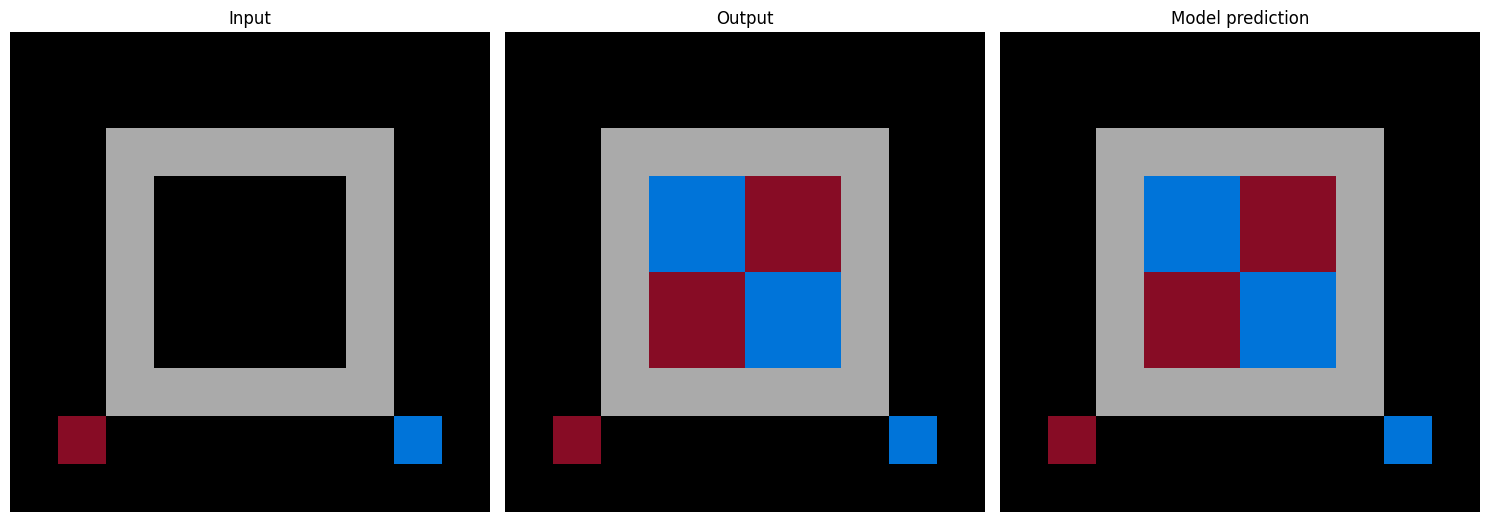

Accuracy:  1.0
dc2e9a9d


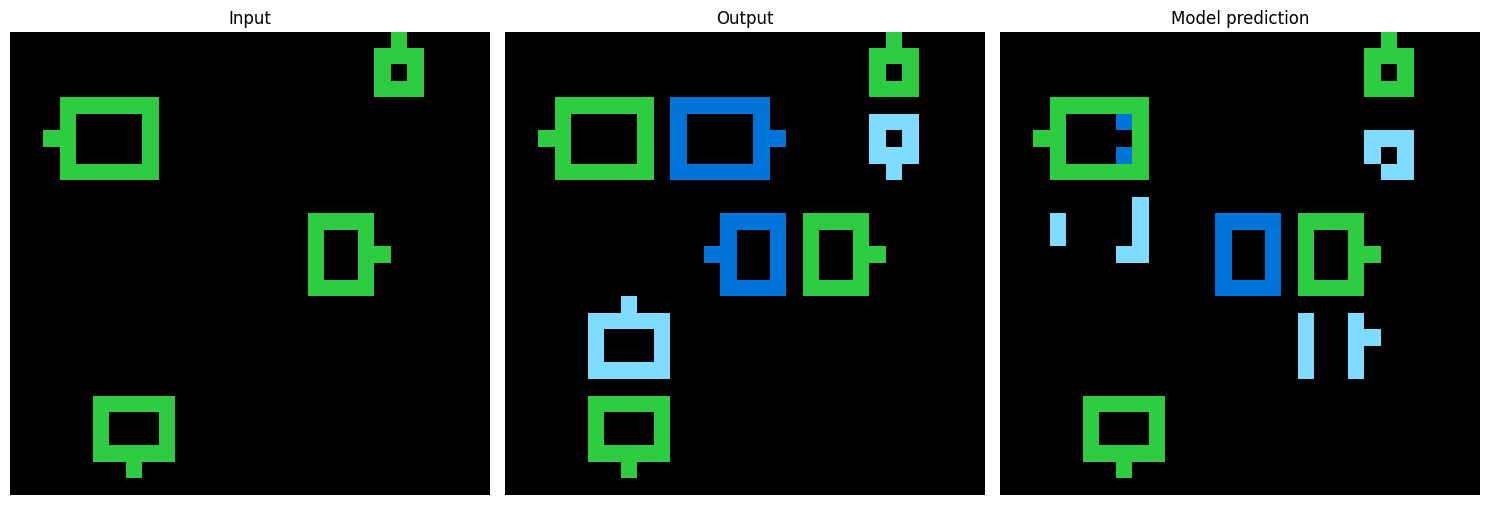

Accuracy:  0.9273399014778325
f83cb3f6


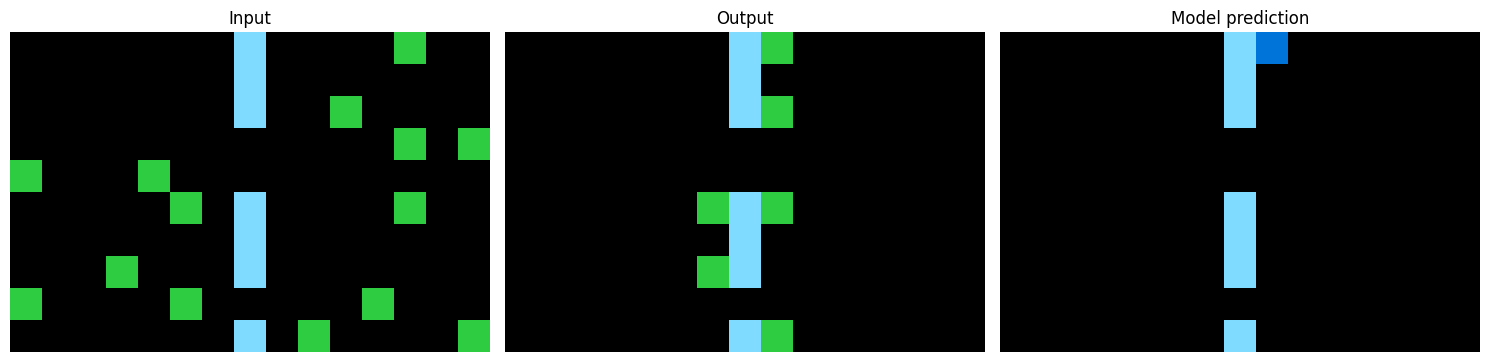

Accuracy:  0.96
baf41dbf


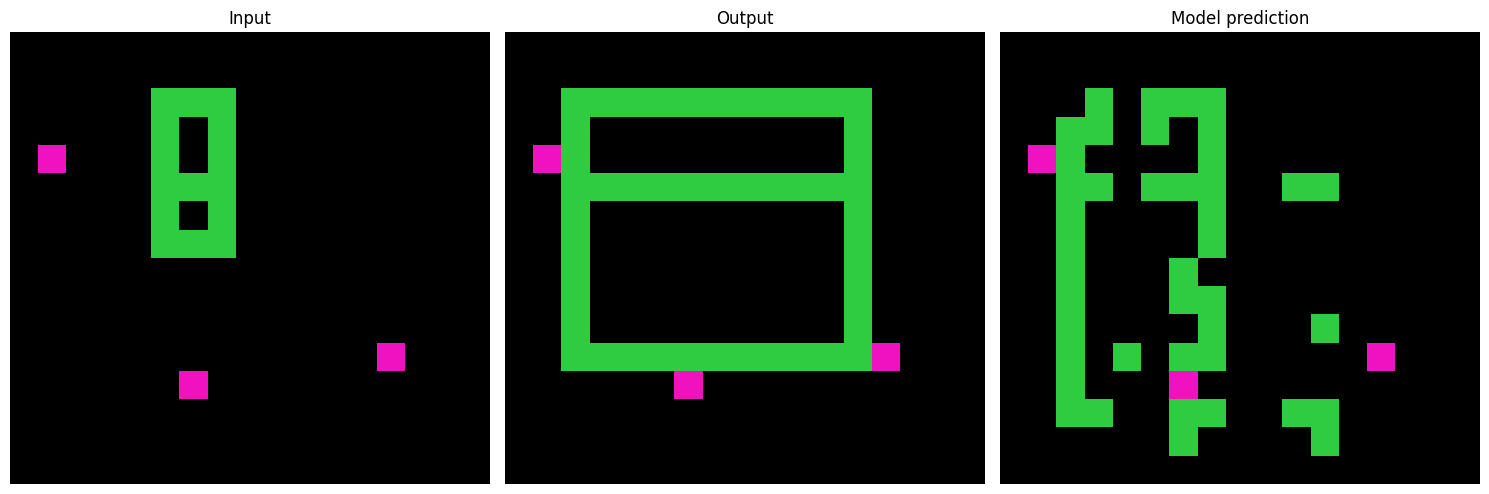

Accuracy:  0.8345588235294118
93b4f4b3
ff72ca3e


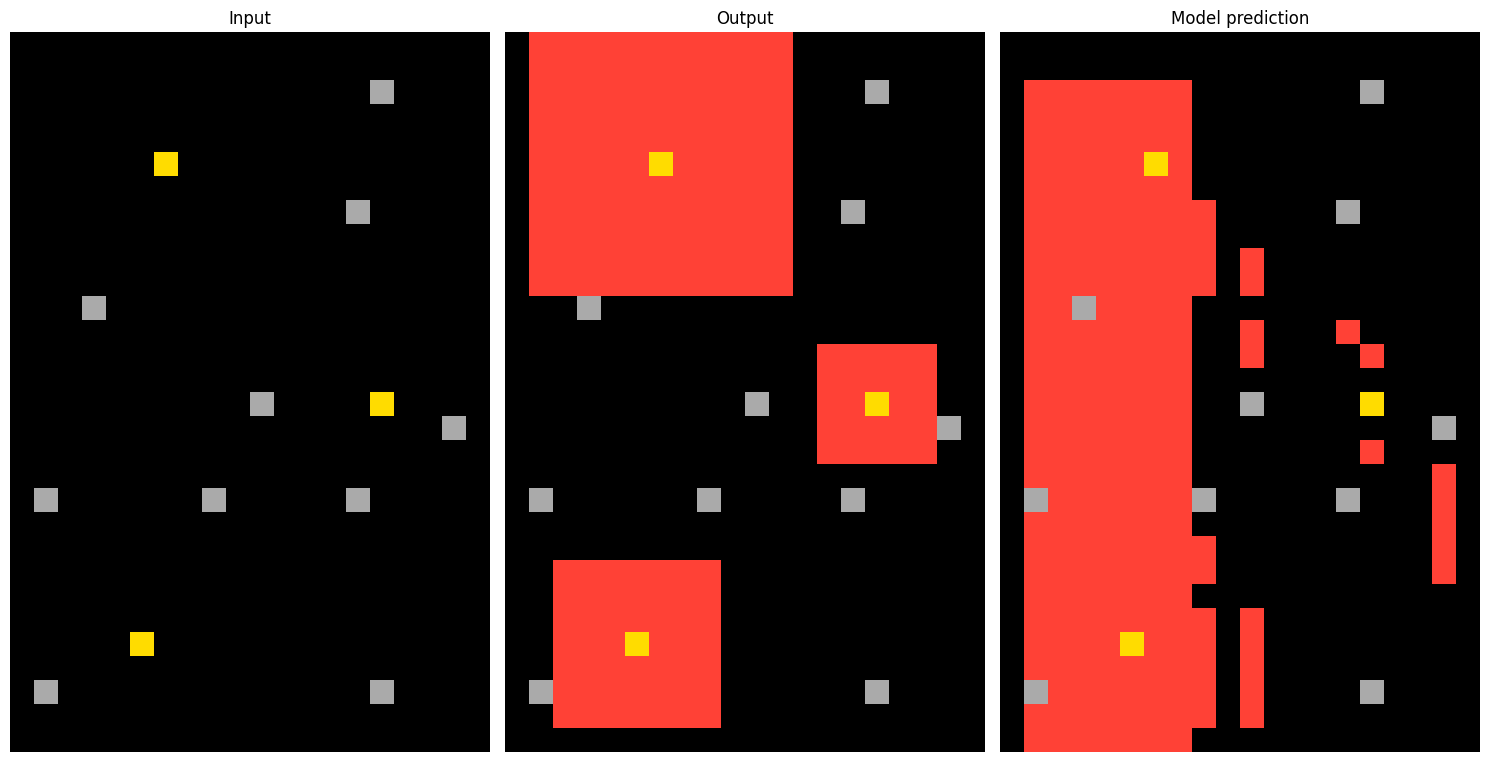

Accuracy:  0.705
50f325b5


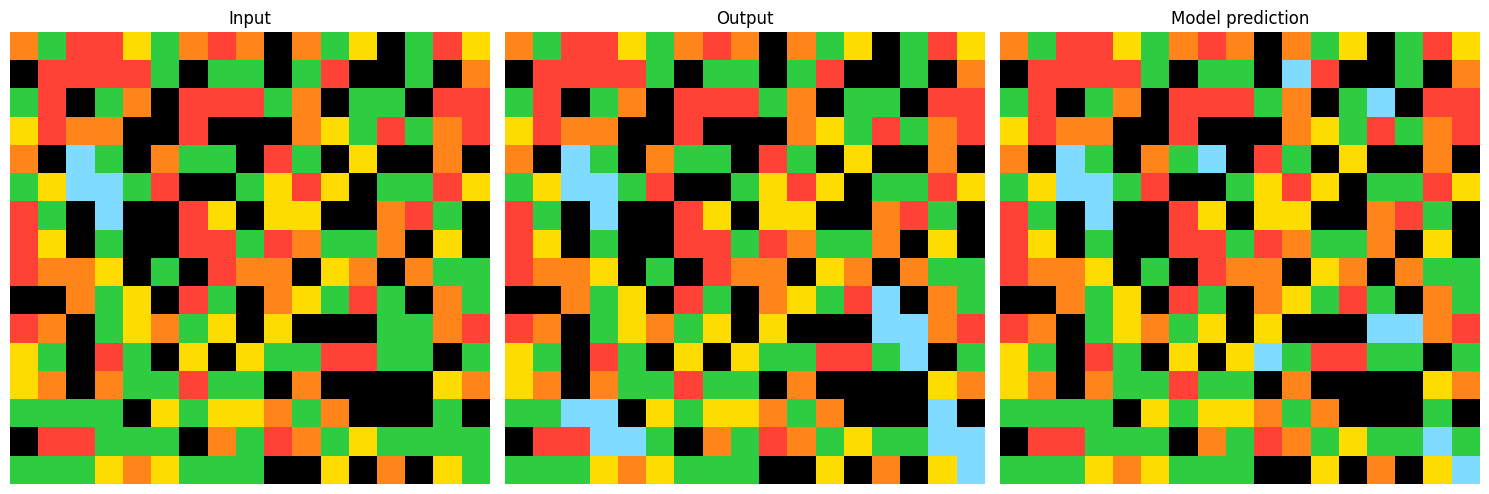

Accuracy:  0.9558823529411765
da515329


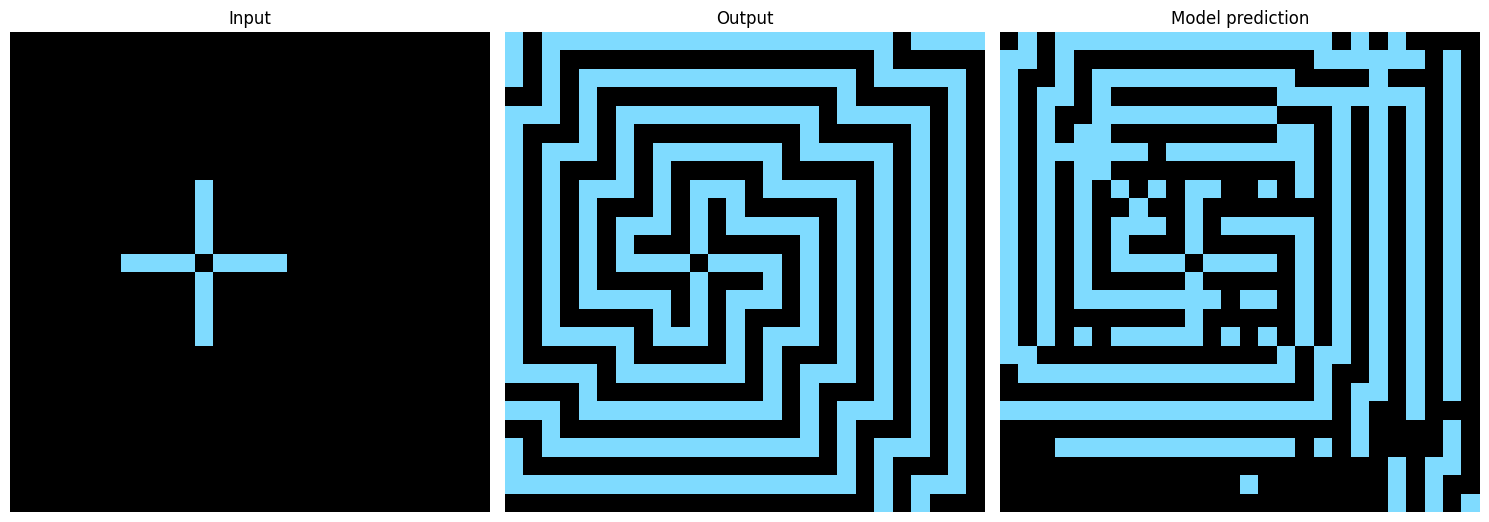

Accuracy:  0.7766272189349113
60a26a3e


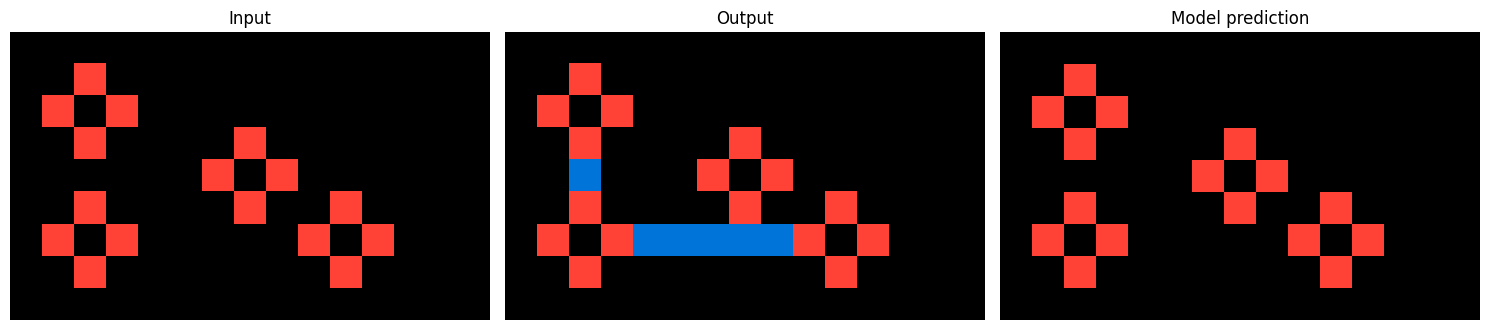

Accuracy:  0.9555555555555556
14754a24


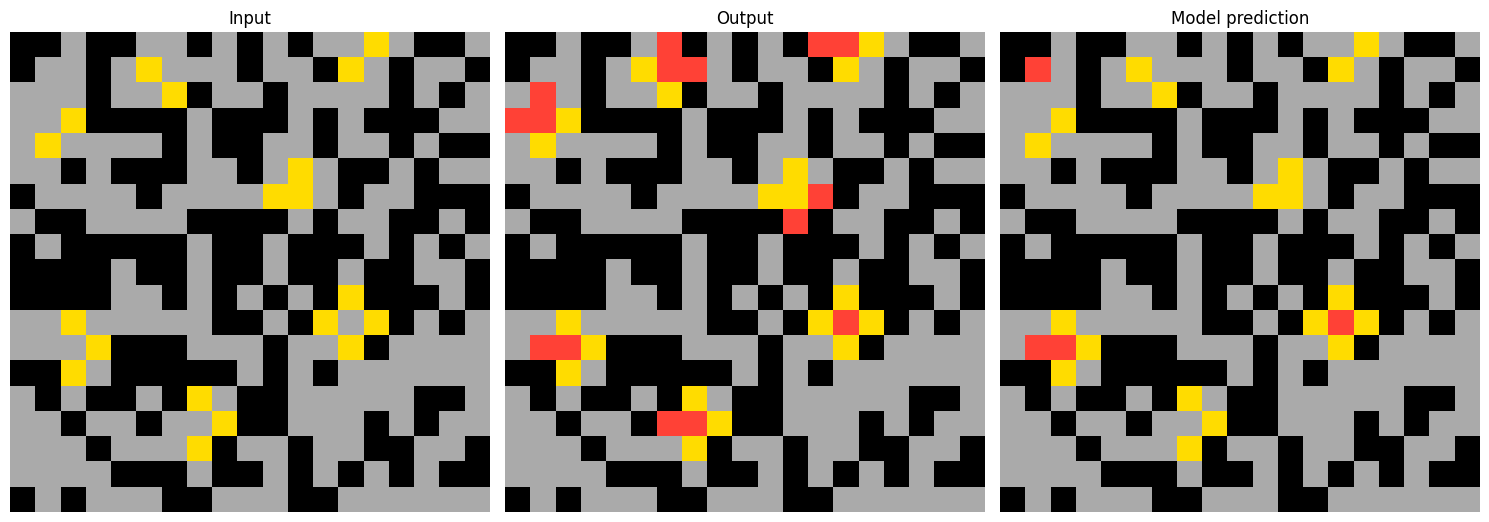

Accuracy:  0.96398891966759
4ff4c9da


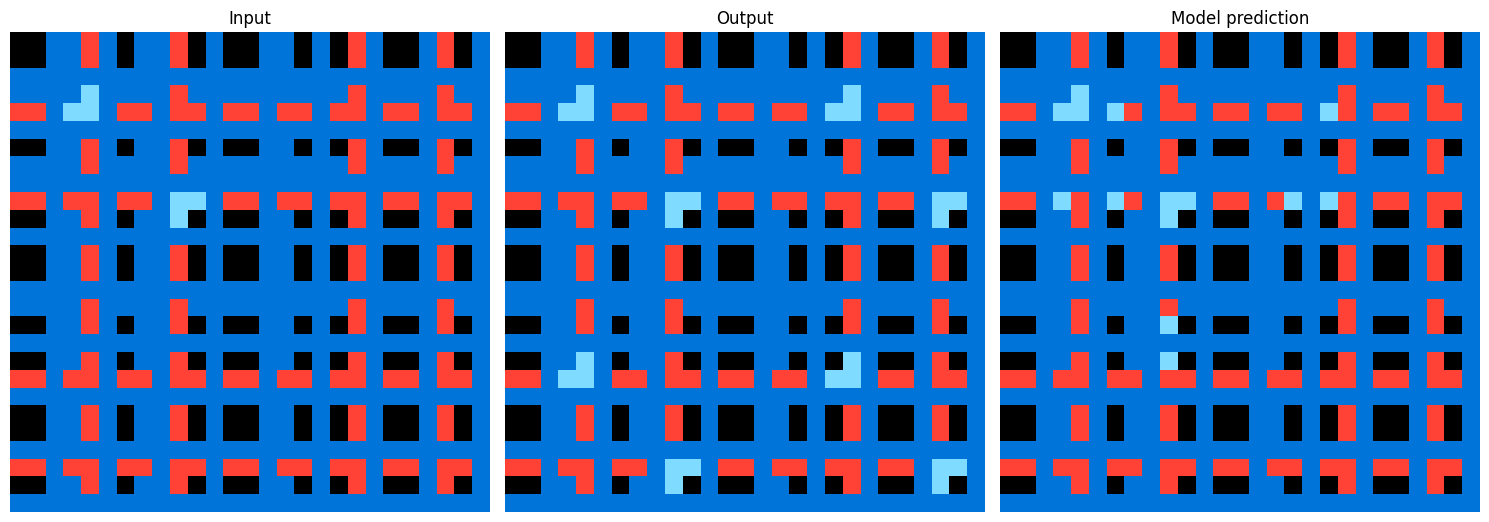

Accuracy:  0.9670781893004116
f9d67f8b


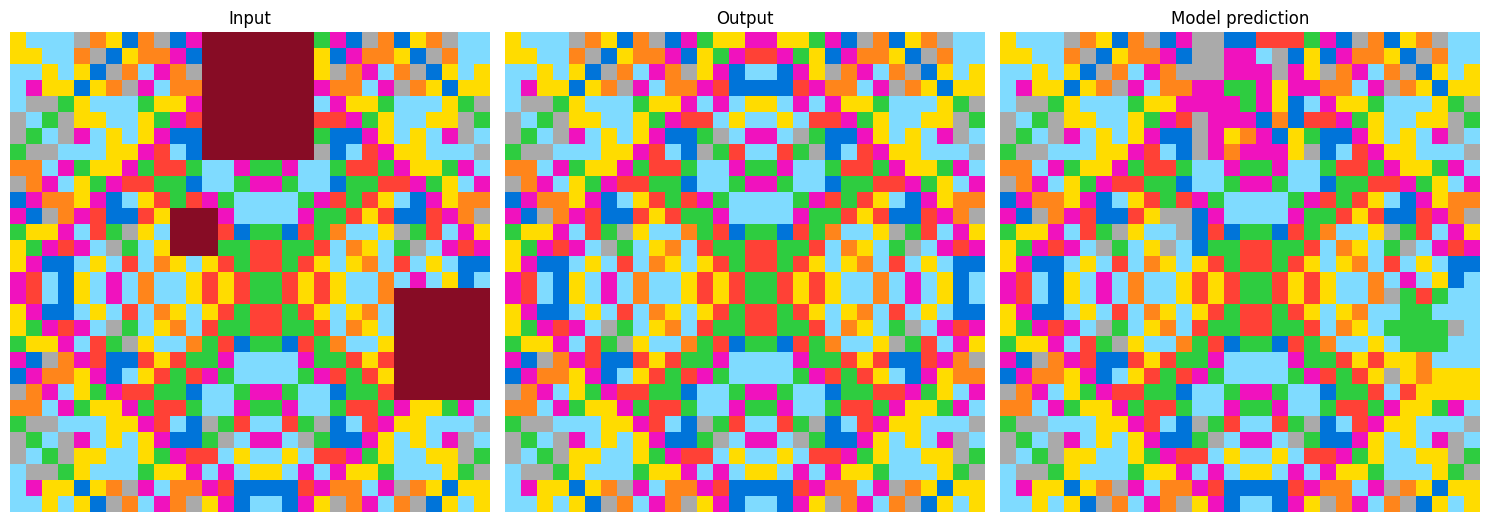

Accuracy:  0.8966666666666666
5ffb2104


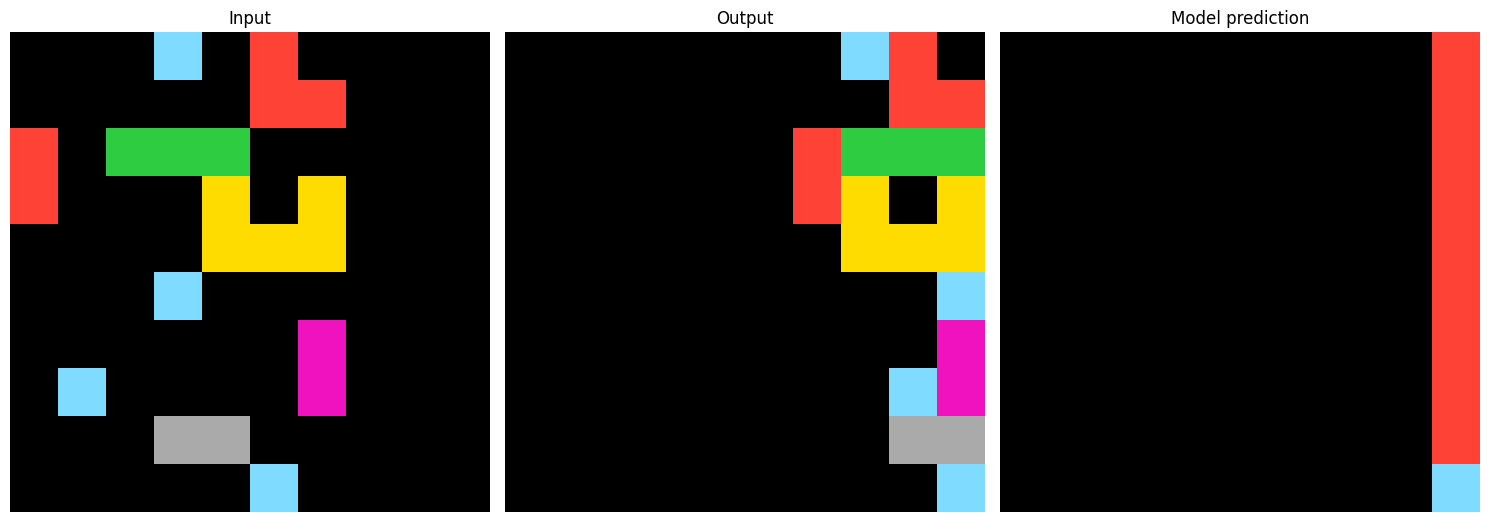

Accuracy:  0.8
2037f2c7
00dbd492


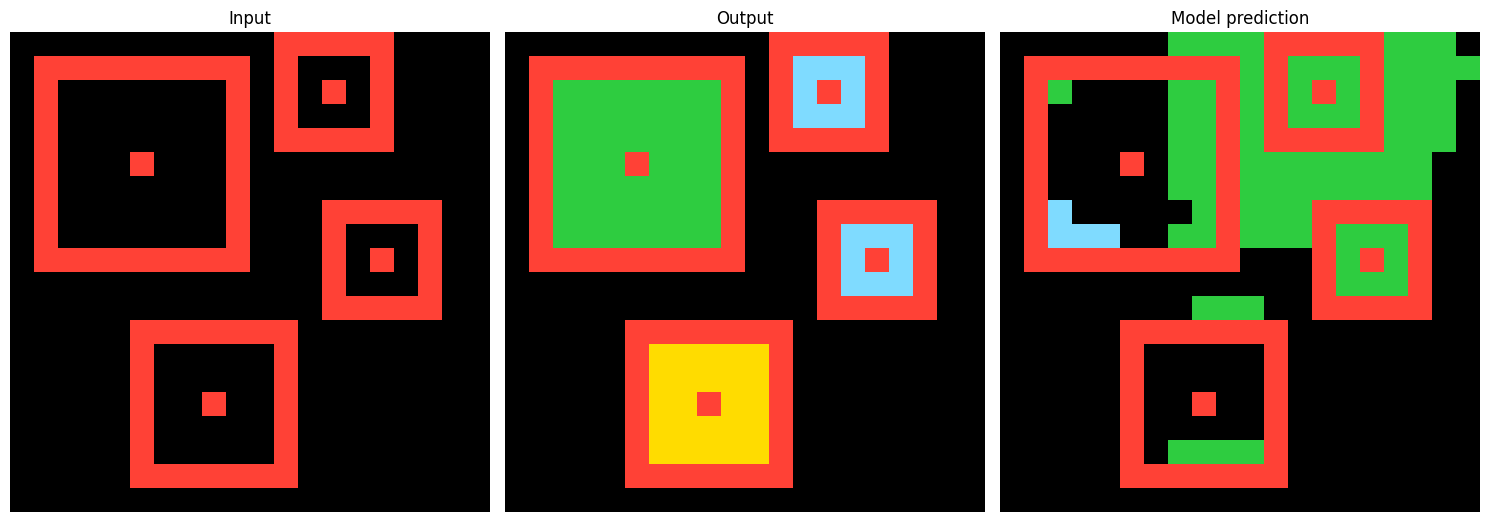

Accuracy:  0.6925
9c1e755f


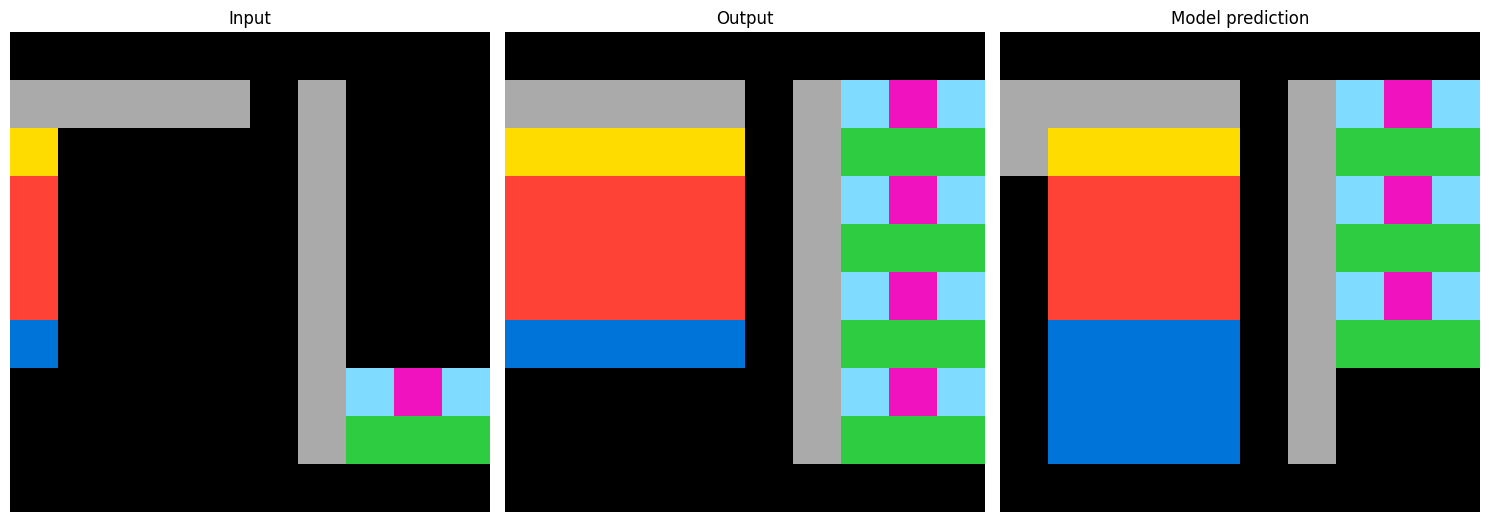

Accuracy:  0.81
6a11f6da
e760a62e


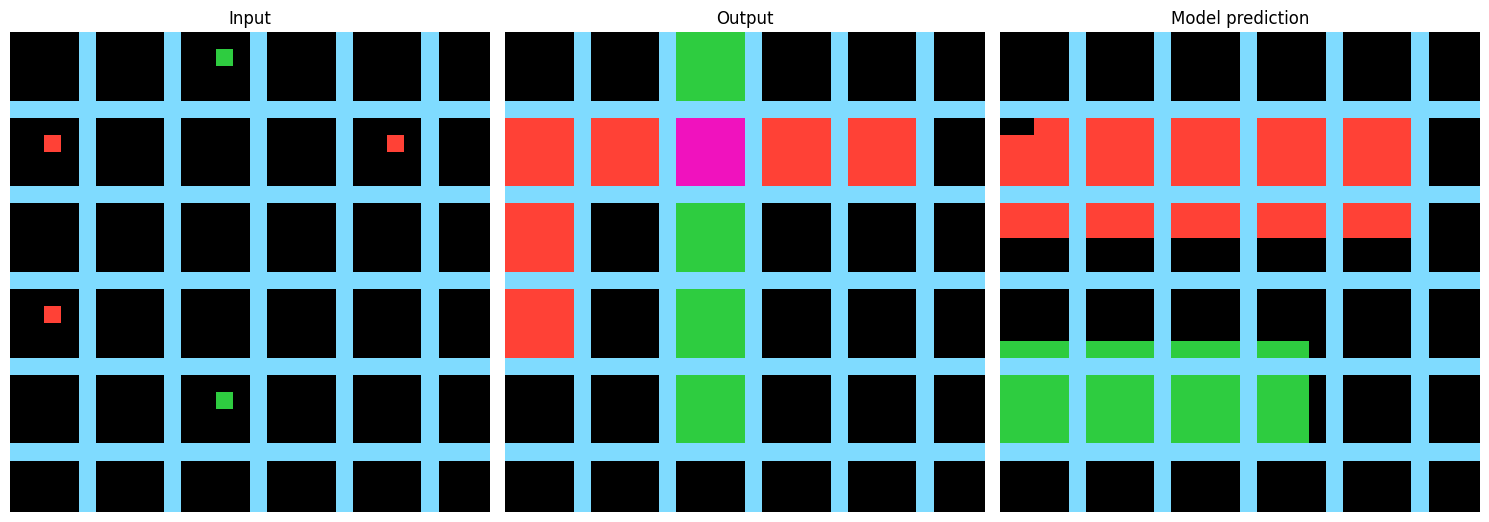

Accuracy:  0.7946428571428571
7bb29440
19bb5feb
6ad5bdfd


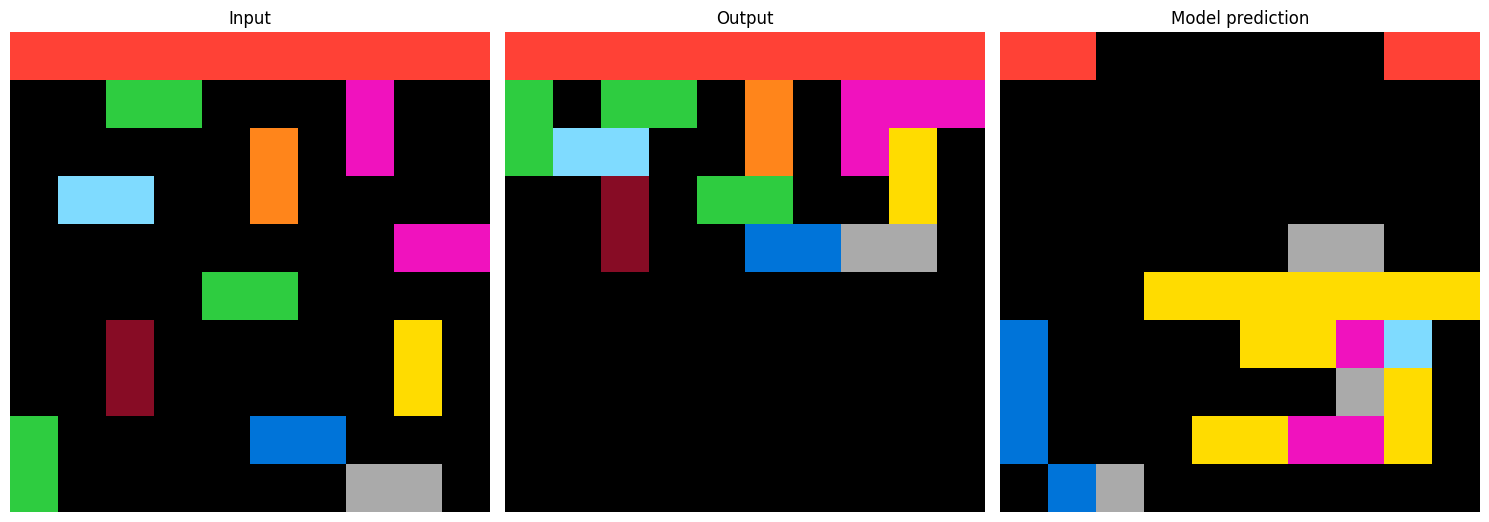

Accuracy:  0.5
891232d6


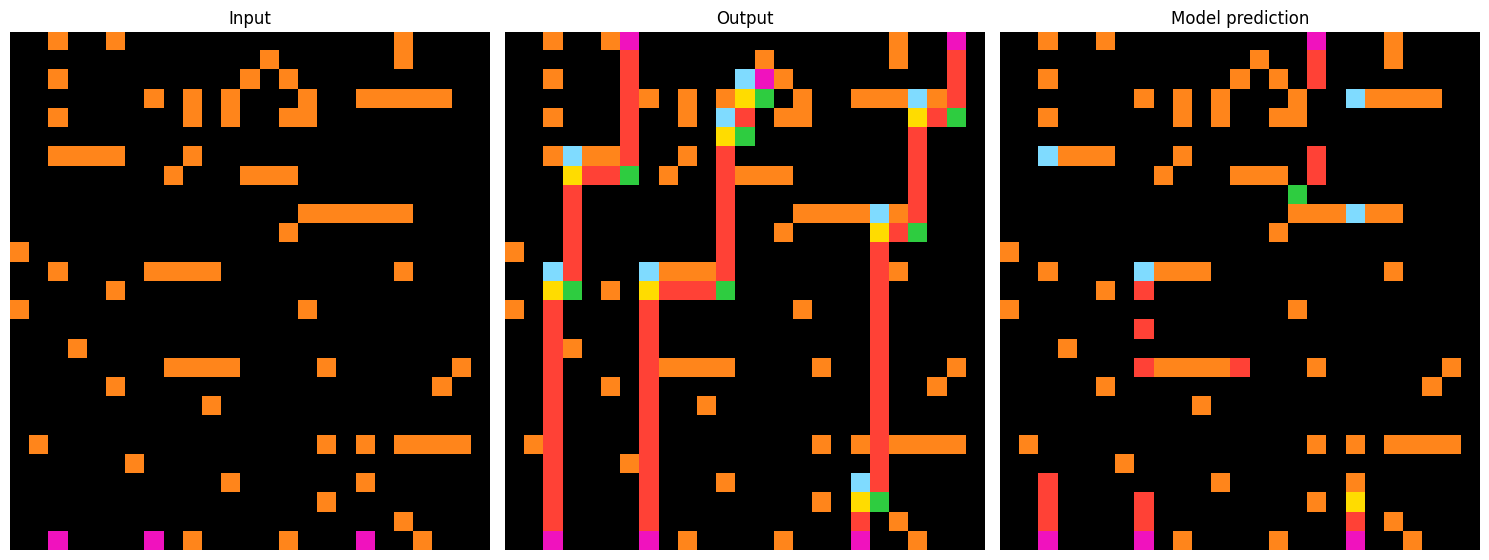

Accuracy:  0.8533333333333334
292dd178


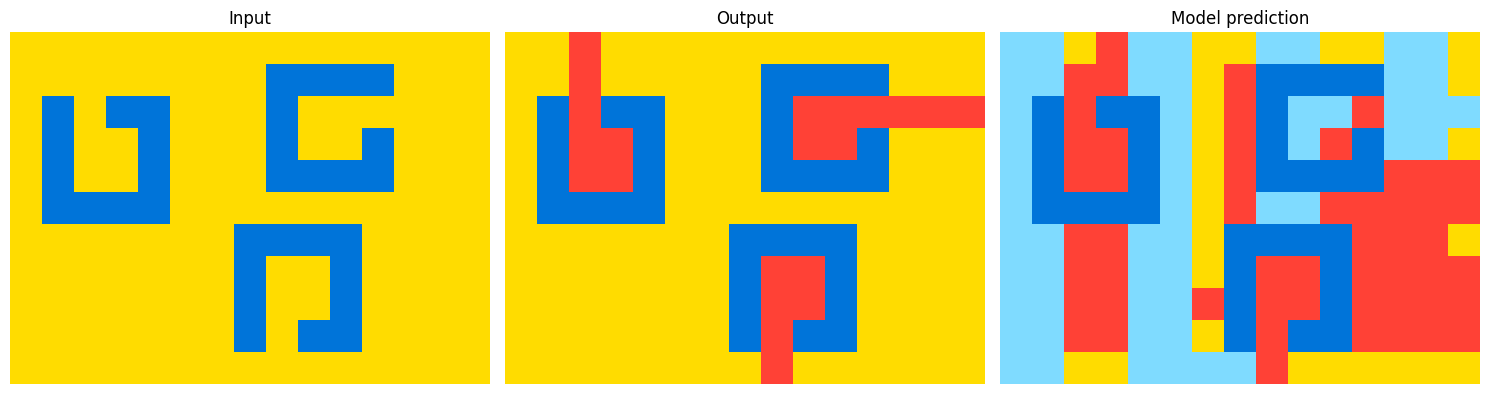

Accuracy:  0.4303030303030303
67b4a34d
94be5b80


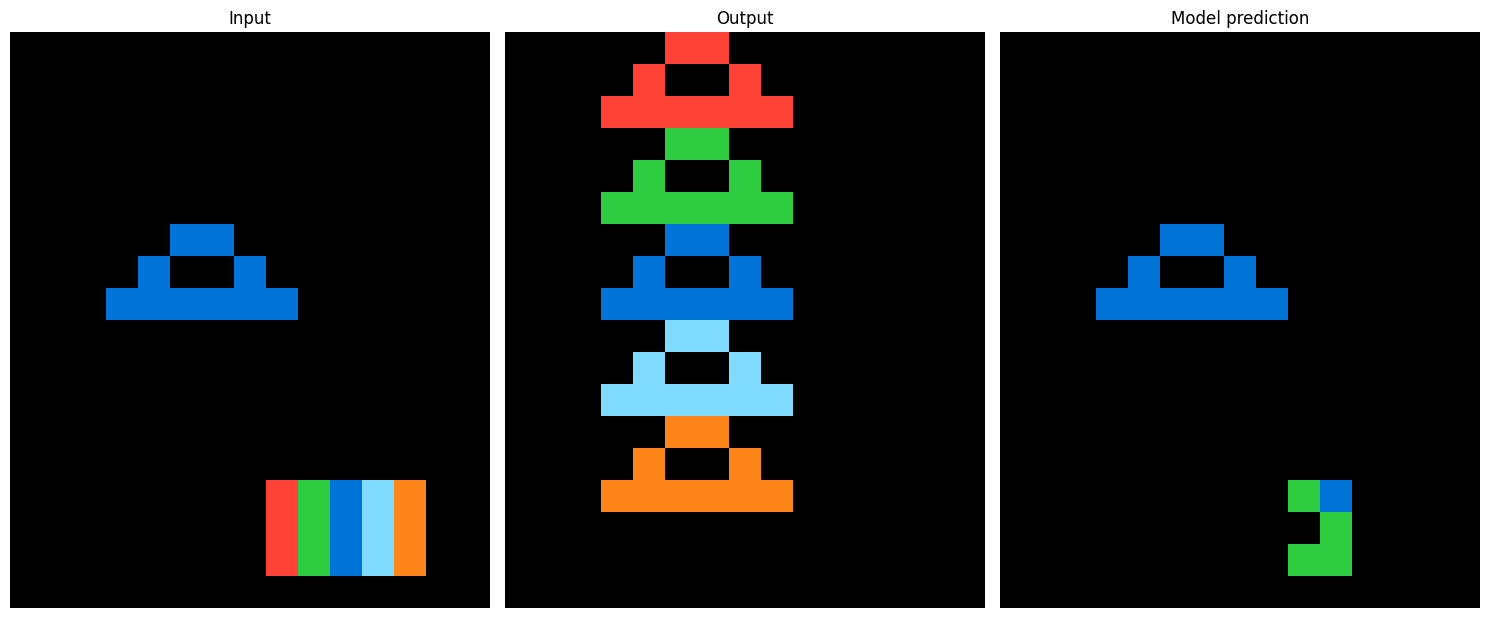

Accuracy:  0.8333333333333334
df8cc377


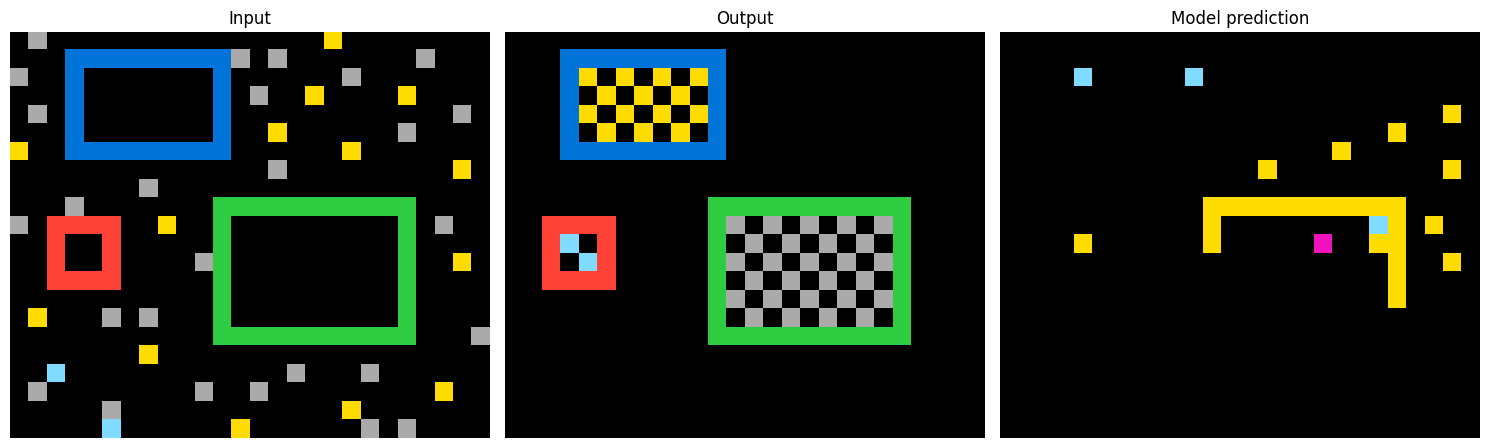

Accuracy:  0.7832167832167832
ce8d95cc
72a961c9


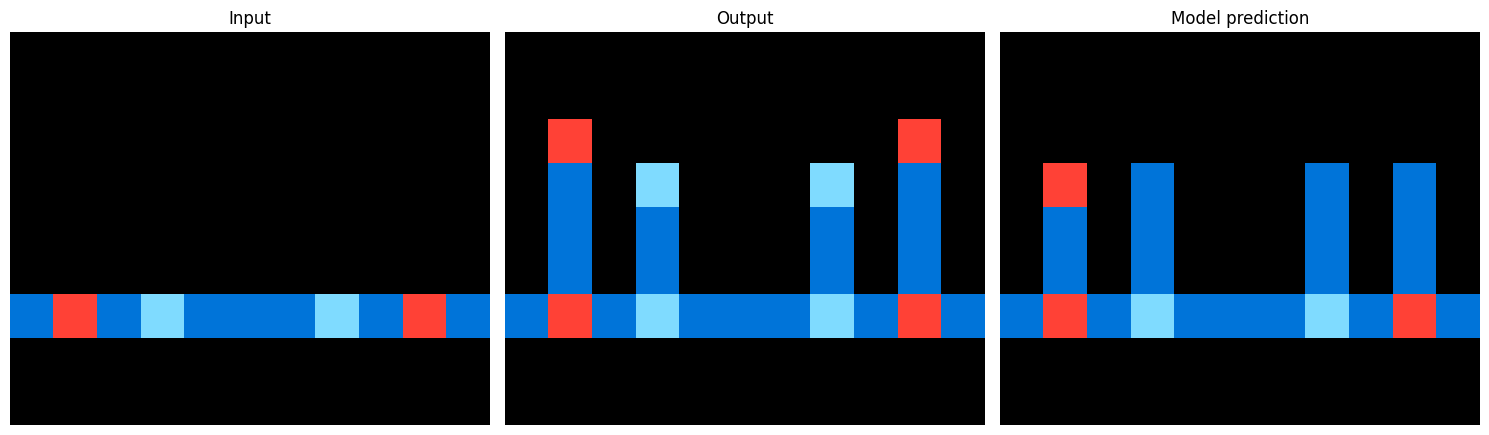

Accuracy:  0.9494949494949495
6f473927
18419cfa


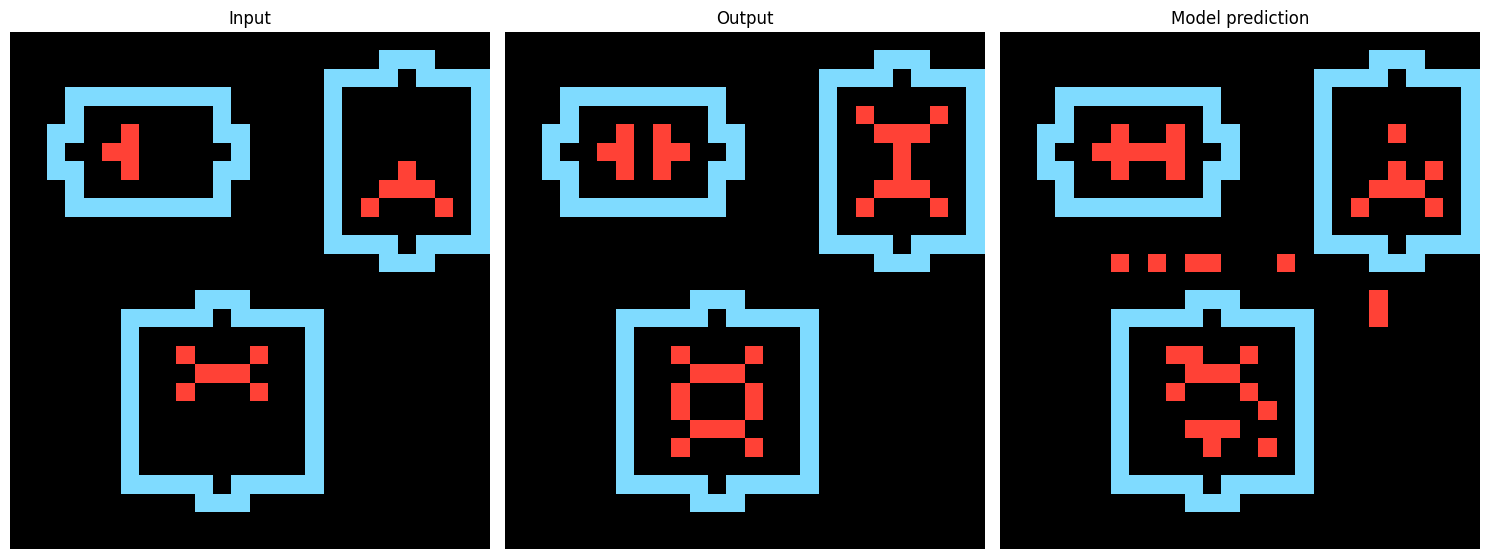

Accuracy:  0.9642857142857143
45bbe264


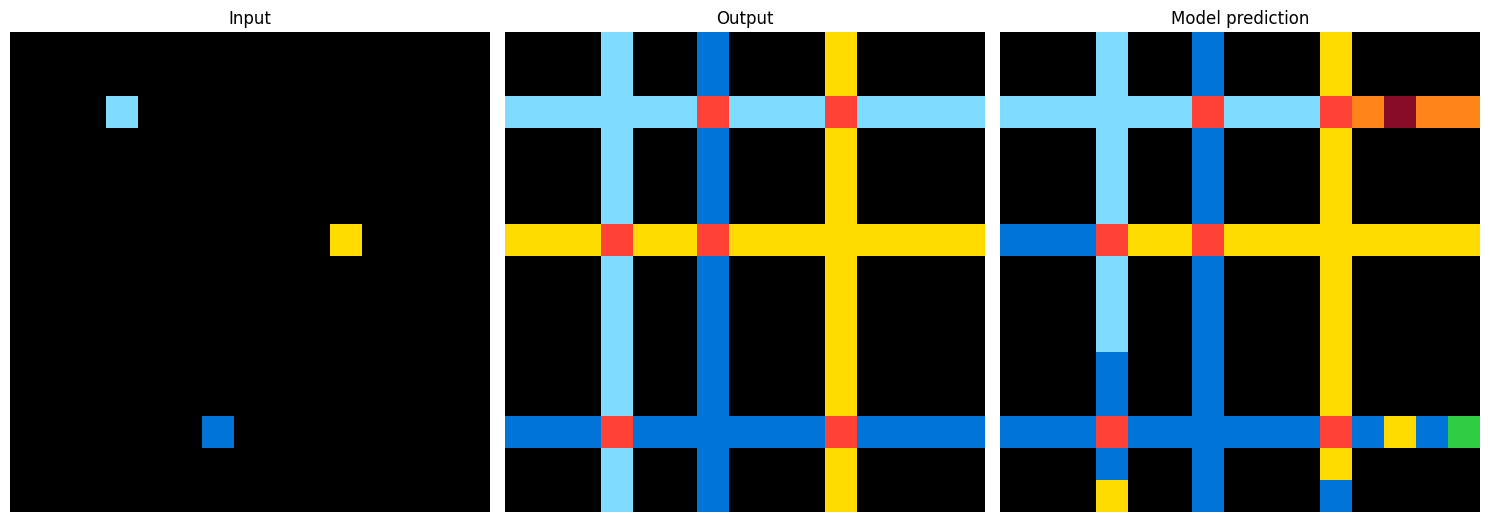

Accuracy:  0.9377777777777778
7c8af763


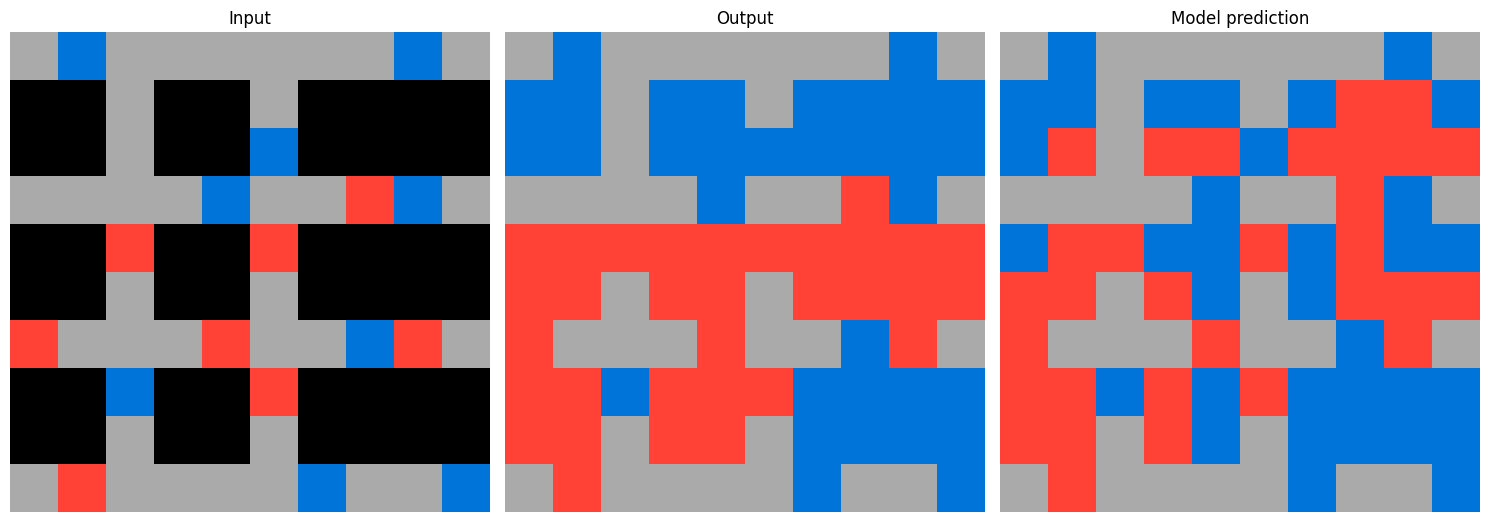

Accuracy:  0.81
f8be4b64


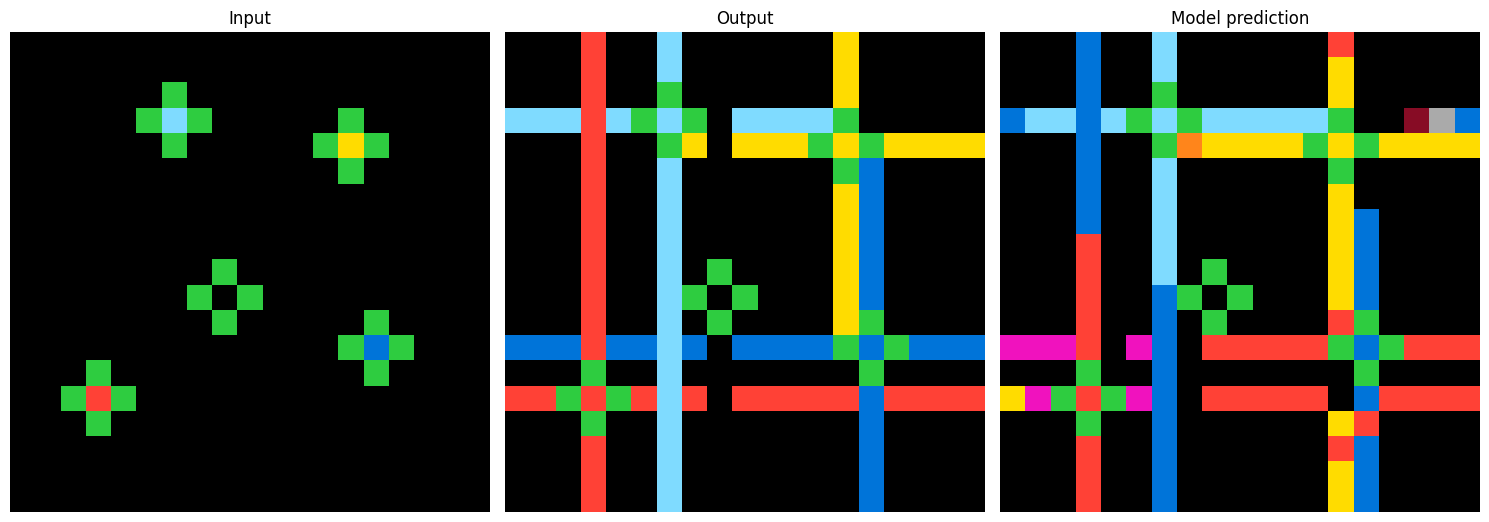

Accuracy:  0.853185595567867
e7dd8335


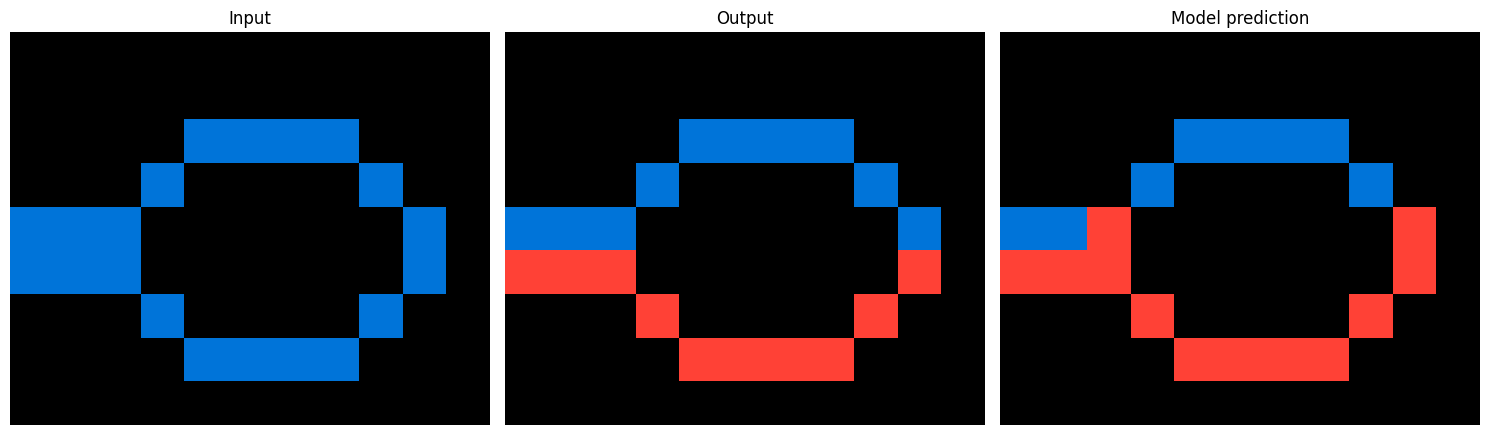

Accuracy:  0.9797979797979798
103eff5b


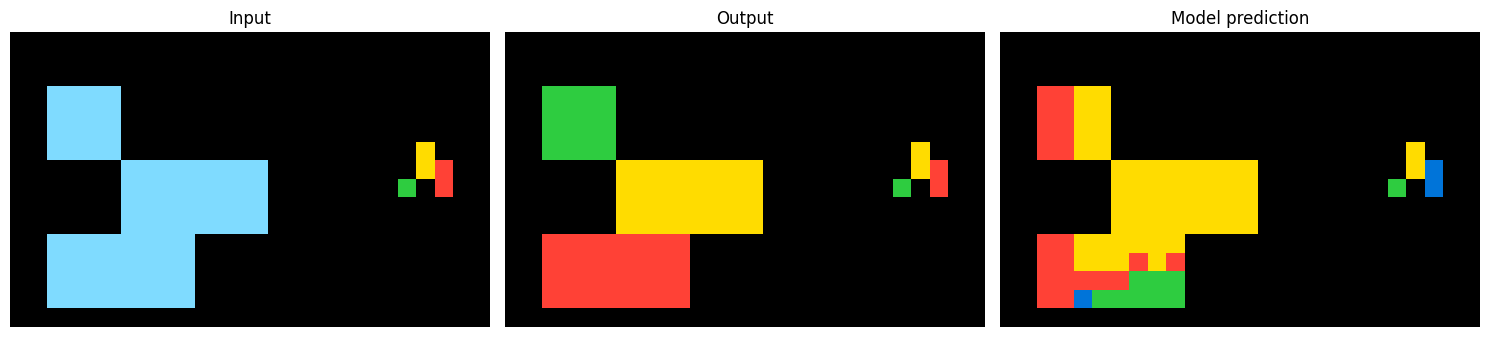

Accuracy:  0.9110576923076923
a57f2f04


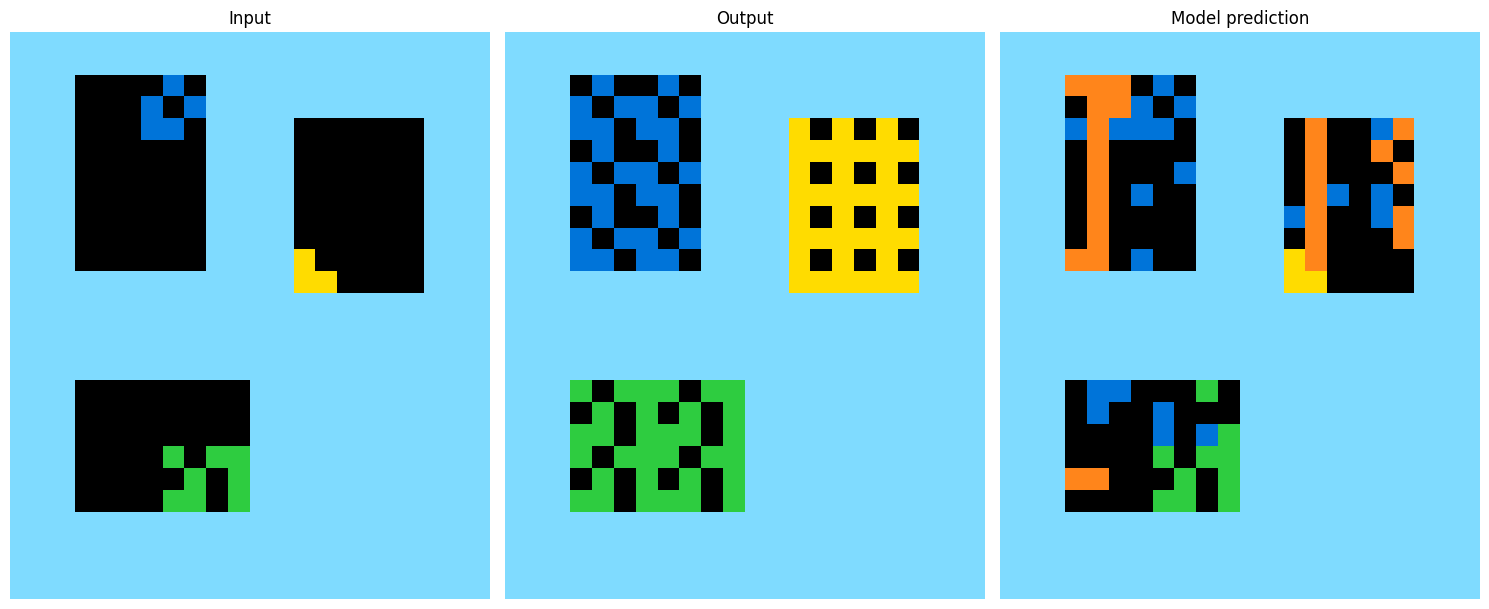

Accuracy:  0.8374125874125874
52fd389e


KeyboardInterrupt: 

In [52]:
def inp_oup_dim_same(task_json):
    return all([ len(pair["input"]) == len(pair["output"]) and len(pair["input"][0]) == len(pair["output"][0])
                for pair in task_json['train']])
    
global total_accuracy
global accuracy100
global accuracy95
global accuracy90
global accuracy80a
global accuracy80b

solved_task = 0
total_task = 0
task_ids = []
task_preds = []
for task_path in test_path.glob("*.json"):
    task_json = json.load(open(task_path))
    tk_id = str(task_path).split("/")[-1].split(".")[0]
    print(tk_id)
    if(inp_oup_dim_same(task_json)):
        a_size = get_a_size(task_json)
        bl_cols = get_bl_cols(task_json)
        
        isflip = False
        X1,Y1 = gettaskxy(task_json,True,1,bl_cols,isflip)
        X3,Y3 = gettaskxy(task_json,True,3,bl_cols,isflip)
        X5,Y5 = gettaskxy(task_json,True,5,bl_cols,isflip)
        X7,Y7 = gettaskxy(task_json,True,7,bl_cols,isflip)
        
        model_1 = BaggingClassifier(estimator=DecisionTreeClassifier(),n_estimators=100).fit(X1, Y1)
        model_3 = BaggingClassifier(estimator=DecisionTreeClassifier(),n_estimators=100).fit(X3, Y3)
        model_5 = BaggingClassifier(estimator=DecisionTreeClassifier(),n_estimators=100).fit(X5, Y5)
        model_7 = BaggingClassifier(estimator=DecisionTreeClassifier(),n_estimators=100).fit(X7, Y7)

        pred_map_1, acc1, inp1, oup1, pred1 = submit_predict(task_json,model_1,1)
        pred_map_3, acc3, inp3, oup3, pred3 = submit_predict(task_json,model_3,3)
        pred_map_5, acc5, inp5, oup5, pred5 = submit_predict(task_json,model_5,5)
        pred_map_7, acc7, inp7, oup7, pred7 = submit_predict(task_json,model_7,7)

        maxacc = max(acc1,acc3,acc5,acc7)

        if maxacc == acc1:
            plot_result(inp1, oup1, pred1)
            total_accuracy += acc1
            print("Accuracy: ", acc1)
            if acc1 == 1:
                accuracy100 += 1
            elif acc1 >= 0.95:
                accuracy95 += 1
            elif acc1 >= 0.9:
                accuracy90 += 1
            elif acc1 >= 0.8:
                accuracy80a += 1
            else:
                accuracy80b += 1

        elif maxacc == acc3:
            plot_result(inp3, oup3, pred3)
            total_accuracy += acc3
            print("Accuracy: ", acc3)
            if acc3 == 1:
                accuracy100 += 1
            elif acc3 >= 0.95:
                accuracy95 += 1
            elif acc3 >= 0.9:
                accuracy90 += 1
            elif acc3 >= 0.8:
                accuracy80a += 1
            else:
                accuracy80b += 1


        elif maxacc == acc5:
            plot_result(inp5, oup5, pred5)
            total_accuracy += acc5
            print("Accuracy: ", acc5)
            if acc5 == 1:
                accuracy100 += 1
            elif acc5 >= 0.95:
                accuracy95 += 1
            elif acc5 >= 0.9:
                accuracy90 += 1
            elif acc5 >= 0.8:
                accuracy80a += 1
            else:
                accuracy80b += 1

        else:
            plot_result(inp7, oup7, pred7)
            total_accuracy += acc7
            print("Accuracy: ", acc7)
            if acc7 == 1:
                accuracy100 += 1
            elif acc7 >= 0.95:
                accuracy95 += 1
            elif acc7 >= 0.9:
                accuracy90 += 1
            elif acc7 >= 0.8:
                accuracy80a += 1
            else:
                accuracy80b += 1


        
        for tks,str_pred in combine_preds(tk_id,pred_map_1,pred_map_3,pred_map_5, pred_map_7):
            task_ids.append(tks)
            task_preds.append(str_pred)
            #print(tks,str_pred)
        solved_task+=1
        #break
    else:
        pred_map_1 = dumb_predict(task_json)
        pred_map_3 = dumb_predict(task_json)
        pred_map_5 = dumb_predict(task_json)
        pred_map_7 = dumb_predict(task_json)
        
        for tks,str_pred in combine_preds(tk_id,pred_map_1,pred_map_3,pred_map_5, pred_map_7):
            task_ids.append(tks)
            task_preds.append(str_pred)
            #print(tks,str_pred)
        
    total_task+=1

In [53]:
print("Total Accuracy: ", total_accuracy/(solved_task))
print("Total Task with accuracy 100: ", accuracy100)
print("Total Task with accuracy 95-100: ", accuracy95)
print("Total Task with accuracy 90-95: ", accuracy90)
print("Total Task with accuracy 80-90: ", accuracy80a)
print("Total Task with accuracy 0-80: ", accuracy80b)


Total Accuracy:  0.8458228307874094
Total Task with accuracy 100:  1
Total Task with accuracy 95-100:  7
Total Task with accuracy 90-95:  4
Total Task with accuracy 80-90:  9
Total Task with accuracy 0-80:  7


In [54]:
solved_task

28